In [31]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency as chi2
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('ggplot')

In [32]:
groups = pd.read_csv("groups.csv", sep=";") \
        .rename(columns={"id":"user_id", "grp": "group"})

group_add = pd.read_csv("group_add.csv", sep=",") \
        .rename(columns={"id":"user_id", "grp": "group"})

active = pd.read_csv("active_studs.csv", sep=";") \
        .rename(columns={"student_id":"user_id"})

check = pd.read_csv("checks.csv", sep=";") \
        .rename(columns={"student_id":"user_id", "rev": "revenue"})

<div class="alert alert-info">
<b>Объединение пользователей из groups.csv и group_add.csv.</b>
</div>

In [33]:
all_users = groups.append(group_add) \
    .reset_index(drop=True) \
    .rename(columns={"id":"user_id"})

all_users

,user_id,group
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


<div class="alert alert-info">
<b>Добавление в active столбеца с пометкой об активности пользователя (active - значит заходил на платформу в дни проведения эксперимента).</b>
</div>

In [34]:
active["active"] = "active"
active

,user_id,active
0,581585,active
1,5723133,active
2,3276743,active
3,4238589,active
4,4475369,active
...,...,...
8336,1794344,active
8337,296883,active
8338,3598448,active
8339,3610547,active


<div class="alert alert-info">
<b>Объединение данных о принадлежности пользователя к контрольной или экспериментальной группе с информацией о посещении платформы в дни проведения эксперимента (active - да, no_active - нет) и с информацией об оплатах пользователей в дни проведения эксперимента.</b>
</div>

In [35]:
df = pd.merge(all_users, active, how="left", on="user_id").fillna("no_active")
df = pd.merge(df, check, how="left", on="user_id")

<div class="alert alert-info">
<b>Добавление столбца с информацией о том совершил ли оплату пользователь.</b>
</div>

In [36]:
df["payment"] = df["revenue"].apply(lambda x: "pay" if x > 0 else "no_pay")

df

,user_id,group,active,revenue,payment
0,1489,B,no_active,NaN,no_pay
1,1627,A,active,990.0,pay
2,1768,B,no_active,NaN,no_pay
3,1783,B,no_active,NaN,no_pay
4,1794,A,no_active,NaN,no_pay
...,...,...,...,...,...
74571,200247820,B,no_active,NaN,no_pay
74572,201032527,B,no_active,NaN,no_pay
74573,201067612,B,no_active,NaN,no_pay
74574,201067653,B,no_active,NaN,no_pay


<div class="alert alert-info">
<b>Филтрация пользователей, которые посещали платформу в дни проведения эксперимента (active).</b>
</div>

In [37]:
active_users = df.query("active == 'active'")[["user_id", "group", "revenue", "payment"]]

active_users

,user_id,group,revenue,payment
1,1627,A,990.0,pay
10,2085,B,NaN,no_pay
12,2215,B,NaN,no_pay
43,3391,A,NaN,no_pay
45,3401,B,NaN,no_pay
...,...,...,...,...
74543,5760471,B,NaN,no_pay
74545,5777081,B,NaN,no_pay
74558,5870856,A,NaN,no_pay
74561,5945085,B,NaN,no_pay


<div class="alert alert-info">
<b>Дополнительная проверка того, были ли оплаты среди пользователей,  которые не заходили на сайт в дни проведения эксперимента (active='no_active')</b>
</div>

In [38]:
paid_users = df.query("active == 'no_active' & revenue > 0")

paid_users

,user_id,group,active,revenue,payment
39,3185,B,no_active,690.0,pay
121,25973,B,no_active,690.0,pay
125,26280,B,no_active,690.0,pay
223,100645,B,no_active,630.0,pay
254,102534,B,no_active,580.0,pay
...,...,...,...,...,...
72452,5291900,B,no_active,199.0,pay
72753,5331842,B,no_active,290.0,pay
73632,5486319,B,no_active,199.0,pay
74049,5562806,B,no_active,398.0,pay


<div class="alert alert-info">
<b>Оказывается есть данные о пользователях, которые не заходили на сайт в дни проведения эксперимента, но при этом совершили оплату. На мой взгляд, такое могло произойти по двум причинам:</b>
    
1. на сайте есть система подписки и у этих пользователей произошло автоматическое продление подписки, хоть на сайт они не заходили.
2. произошла ошибка в сборе данных и часть пользователей, которые заходили на сайт в дни проведения эксперимента, были помечены, как no_active. В таком случае стоит учесть этих пользователей при проведении A/B теста.
</div>

<div class="alert alert-info">
<b>Проработаем вариант номер 2. Объединение данных по активным пользователям и не активным, но совершившим оплату.</b>
</div>

In [39]:
active_users = pd.concat([active_users, paid_users[['user_id', 'group', 'revenue', 'payment']]], ignore_index=True)

active_users

,user_id,group,revenue,payment
0,1627,A,990.0,pay
1,2085,B,NaN,no_pay
2,2215,B,NaN,no_pay
3,3391,A,NaN,no_pay
4,3401,B,NaN,no_pay
...,...,...,...,...
8485,5291900,B,199.0,pay
8486,5331842,B,290.0,pay
8487,5486319,B,199.0,pay
8488,5562806,B,398.0,pay


<div class="alert alert-info">
<b>Сравнение количество активных пользователей (которые зашли на платформу в дни проведения эксперимента) в тестовой и контрольной группе.</b>
</div>

<AxesSubplot:xlabel='group', ylabel='Count'>

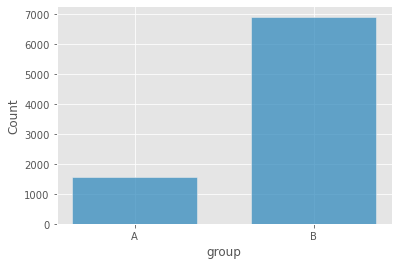

In [40]:
sns.histplot(data=active_users[["group", "user_id"]], x="group", shrink=.7)

<div class="alert alert-info">
<b>Сведение активных пользователей в кросс-таблицу по принадлежности к контрольной/тестовой группе и факту оплаты на платформе. Кросс-таблица покажет количество активных пользователей совершивших и не совершивших оплату в каждой из групп.</b>
</div>

In [41]:
payment_group = pd.crosstab(active_users["group"], active_users["payment"])

payment_group

payment,no_pay,pay
group,,
A,1460,107
B,6489,434


<div class="alert alert-info">
<b>Количество оплативших и не оплативших пользователей в тестовой и контрольной группе отличается. Однако, делать вывод только по цифрам – не очень хорошо. Нужно применить статистический тест и понять является разница стат.значимой.</b>
</div>

<div class="alert alert-info">
<b>Гипотезы:
    
- $H_0$ : Количество оплативших и не оплативших пользователей в тестовой и контрольной группе стат.значимо НЕ различается
- $H_1$ : Количество оплативших и не оплативших пользователей в тестовой и контрольной группе стат.значимо различается</b>
</div>

<div class="alert alert-info">
<b>Поскольку сравниваем две категориальные переменные (group и payment), нужен хи-квадрат</b>
</div>

In [42]:
stat, p, dof, expected = chi2(payment_group)

stat, p

(0.579666003588264, 0.4464432666411111)

<div class="alert alert-info">
<b>Полученное значение p_value > 0.05, что все равно случае не дает основания отклонить $Н_0$, т.е. нет оснований утверждать, что количество оплативших и не оплативших пользователей в тестовой и контрольной группе стат.значимо различается</b>
</div>

<div class="alert alert-info">
<b>Однако, само по себе количество оплат показатель не очень информативный. Поэтому дополнительно стоит сравнить средний чек среди активных пользователей в разрезе групп (контрольной и тестовой). Будем считать активными тех пользователей, которые заходили на сайт в дни проведения эксперимента и тех, кто не заходил, но совершил оплату.</b>
</div>

In [43]:
active_users

,user_id,group,revenue,payment
0,1627,A,990.0,pay
1,2085,B,NaN,no_pay
2,2215,B,NaN,no_pay
3,3391,A,NaN,no_pay
4,3401,B,NaN,no_pay
...,...,...,...,...
8485,5291900,B,199.0,pay
8486,5331842,B,290.0,pay
8487,5486319,B,199.0,pay
8488,5562806,B,398.0,pay


<div class="alert alert-info">
<b>Рассчет количества пользователей, совершивших оплату, в разрезе групп.</b>
</div>

In [44]:
paid_users = active_users \
                .query("payment == 'pay'") \
                .groupby('group', as_index=False) \
                .agg({'user_id': 'count'}) \
                .rename(columns={'user_id': 'paid_users'})

paid_users

,group,paid_users
0,A,107
1,B,434


<div class="alert alert-info">
<b>Рассчитаем суммарный доход в разрезе групп.</b>
</div>

In [45]:
total_revenue = active_users \
                    .groupby('group', as_index=False) \
                    .agg({'revenue': 'sum'}) \
                    .rename(columns={'user_id': 'total_revenue'})

total_revenue

,group,revenue
0,A,92096.0000
1,B,481230.0036


<div class="alert alert-info">
<b>Объединение paid_users и total_revenue и расчет среднего чека (Average Order Value)</b>
</div>

<div class="alert alert-info">
<b>Также построим boxplot оплат в разрезе групп.</b>
</div>

In [46]:
data = pd.merge(paid_users, total_revenue, how="left", on="group")

data

,group,paid_users,revenue
0,A,107,92096.0000
1,B,434,481230.0036


In [47]:
data['aov'] = data['revenue'] / data['paid_users']

data

,group,paid_users,revenue,aov
0,A,107,92096.0000,860.710280
1,B,434,481230.0036,1108.824893


<AxesSubplot:xlabel='group', ylabel='revenue'>

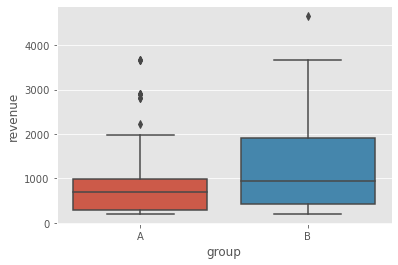

In [48]:
revenue_by_groups = active_users.query("payment == 'pay'")[['group', 'revenue']]

sns.boxplot(x="group", y="revenue", data=revenue_by_groups)

<div class="alert alert-info">
<b>По табличным значениям и по визуализации видно, что средний чек для тестовой и контрольной группы отличается. В тестовой группе средний чек больше. Необходимо провести A/B тест и выяснить является ли эта разница стат.значимой</b>
</div>

<div class="alert alert-info">
<b>Также по графику видим, что есть выбросы. В данном случае их можно оставить, поскольку это вполне могли быть редкие покупки на суммы больше среднего</b>
</div>

<div class="alert alert-info">
<b>Посмотрим на распределения revenue по группам.</b>
</div>

/Users/a.gavrilik/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


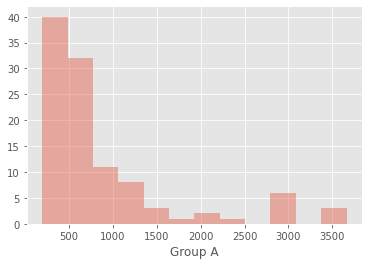

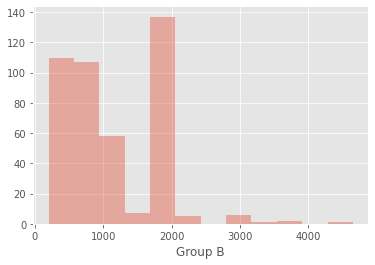

In [49]:
A = revenue_by_groups.query("group == 'A'")['revenue']
sns.distplot(A, kde=False, axlabel='Group A')
plt.show()

B = revenue_by_groups.query("group == 'B'")['revenue']
sns.distplot(B, kde=False, axlabel='Group B')
plt.show()

<div class="alert alert-info">
<b>Распределения отличаются от нормальных. Но, поскольку значений в обеих выборках (A и B) много (более 30) можно провести A/B без приведения данных к нормальному виду. Применим t-test.</b>
</div>

In [50]:
ttest_ind(A, B)

Ttest_indResult(statistic=-3.0367637315797342, pvalue=0.0025070167572044375)

<div class="alert alert-info">
<b>t-test показал p-value < 0.05 (pvalue=0.0025070167572044375), что дает основания отвергнуть нулевую гипотезу о равенстве средних.</b>
</div>

<div class="alert alert-info">
<b>Т.е. можно сделать вывод, что средние чеки двух выборок (двух групп пользователей) стат.значимо различаются.</b>
</div>

<div class="alert alert-info">
<b>Для уверенности нормализуем значения в обеих выборках (A и B), применив логарифмирование и повторим A/B тест.</b>
</div>

In [51]:
A_log = np.log(A)
B_log = np.log(B)

<div class="alert alert-info">
<b>Смотрим на распределения revenue по группам</b>
</div>

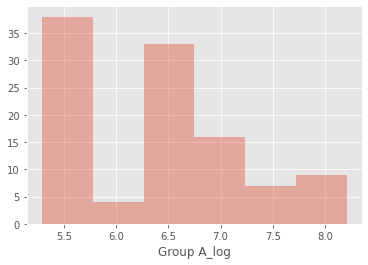

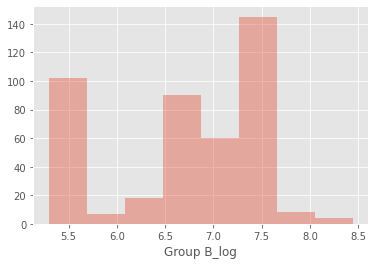

In [52]:
sns.distplot(A_log, kde=False, axlabel='Group A_log')
plt.show()

sns.distplot(B_log, kde=False, axlabel='Group B_log')
plt.show()

In [53]:
ttest_ind(A_log, B_log)

Ttest_indResult(statistic=-3.53172600119997, pvalue=0.0004482400492255275)

<div class="alert alert-info">
<b>t-test снова показал p-value < 0.05 (pvalue=0.0004482400492255275), что дает основания отвергнуть нулевую гипотезу о равенстве средних.</b>
</div>

<div class="alert alert-info">
<b>Т.е. можно сделать вывод, что средние чеки двух выборок (двух групп пользователей) стат.значимо различаются.</b>
</div>

<div class="alert alert-success">
    
<h1>Итоговый вывод и ответы на вопросы:</h1>
</div>

<div class="alert alert-success">
    
<b>1. На какие метрики Вы смотрите в ходе анализа и почему?</b>

Поскольку речь идет о тестировании нового механизма оплаты, то при проведении A/B тестирования нужно обратить внимание на факт оплаты пользователем услуг на сайте и средний чек. Это и есть освноные метрики для тестирования нового механизма оплаты.

<b>!В общем на основании имеющихся данных можно дополнительно рассчитать следующие метрики:</b>
- <b>Доля активных пользователей (Active Users Rate)</b> – количество пользователей заходивших на сайт в дни проведения эксперимента деленное на общее количество пользователей.
- <b>Общий доход (Summary Revenue), средний чек (Average Order Value)</b> в дни проведения эксперимента.
- <b>Конверсия активного пользователя в оплату (CR Active)</b> – количество активных пользователей совершивших оплату деленное на общее количество активных пользователей.
- <b>Конверсия не активного пользователя в оплату (CR No Active)</b> – количество не активных пользователей совершивших оплату деленное на общее количество не активных пользователей.
- <b>ARPU</b> – общий доход за время проведения эксперимента деленный на количество активных пользователей.
- <b>ARPAU</b> – средний платеж деленный на количество активных пользователей.
</div>

<div class="alert alert-success">
    
<b>2. Имеются ли различия в показателях и с чем они могут быть связаны?</b>

Если смотреть на количество оплат среди активных в дни проведения эксперимента пользователей, то кажется, что есть различия. Но делать выводы только на разнице в числах - это не верный подход. Нужно провести A/B тест и понять, является ли разница статистически значимой.
</div>

<div class="alert alert-success">
    
<b>3. Являются ли эти различия статистически значимыми?</b>

A/B тест (статистический тест Стьюдента(ttest_ind)) разницы средних чеков в разрезе групп (контрольной и тестовой) показал p-value < 0.05, что дает основания сделать вывод, что средние чеки двух выборок (двух групп пользователей) стат.значимо различаются. Т.е. среди пользователей тестовой группы средний чек стат.значимо выше.
</div>
    
<div class="alert alert-success">
    
<b>4. Стоит ли запускать новую механику на всех пользователей?</b>

Да, стоит.
</div>